RAG with colpali, on whole pdfs, tables or images

Download files from arxiv

In [1]:
import json
import re
import os
import requests

class ArxivPaperFilterDownloader:
    def __init__(self, metadata_file, output_dir):
        self.metadata_file = metadata_file
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def parse_comments(self, comments):
        """
        Extracts the number of pages and figures from the comments field.
        """
        pages = None
        figures = None
        if comments:
            # Extract number of pages (e.g., "37 pages", "7 Pages")
            pages_match = re.search(r"(\d+)\s*[Pp]ages?", comments)
            if pages_match:
                pages = int(pages_match.group(1))

            # Extract number of figures (e.g., "14 figures", "19 Figures")
            figures_match = re.search(r"(\d+)\s*[Ff]igures?", comments)
            if figures_match:
                figures = int(figures_match.group(1))
        return pages, figures

    def filter_papers(self, output_file, category, year, max_pages=None, min_figures=None, limit=-1):
        """
        Filters papers from the metadata file based on the specified criteria.

        Parameters:
            output_file (str): Path to save the filtered paper IDs.
            category (str): The category to filter papers by (e.g., 'cs.AI').
            year (str): The year to filter papers by (e.g., '2023').
            max_pages (int): Maximum number of pages allowed. If None, no restriction.
            min_figures (int): Minimum number of figures required. If None, no restriction.
            limit (int): Maximum number of results to include in the output. If -1, no limit.

        Returns:
            int: The number of papers that matched the criteria.
        """
        count = 0
        with open(self.metadata_file, "r") as f, open(output_file, "w") as out_f:
            for line in f:
                try:
                    paper = json.loads(line)
                    # Check if the paper matches the specified category
                    if category in paper.get("categories", ""):
                        # Check if the year exists anywhere in the versions list
                        versions_str = str(paper.get("versions", ""))
                        if year in versions_str:
                            # Parse the comments field for pages and figures
                            comments = paper.get("comments", "")
                            pages, figures = self.parse_comments(comments)

                            # Apply additional filters for pages and figures
                            if (max_pages is None or (pages is not None and pages <= max_pages)) and \
                               (min_figures is None or (figures is not None and figures >= min_figures)):
                                out_f.write(f"{paper['id']}\n")
                                count += 1

                                # Stop if the limit is reached
                                if limit != -1 and count >= limit:
                                    break
                except (KeyError, json.JSONDecodeError):
                    continue  # Skip any malformed entries

        print(f"Found {count} papers in category '{category}' from {year} matching the criteria.")
        return count

    def download_pdfs(self, id_file):
        """
        Downloads PDFs for the IDs listed in the specified file.

        Parameters:
            id_file (str): Path to the file containing paper IDs.
        """
        with open(id_file, "r") as f:
            for paper_id in f:
                paper_id = paper_id.strip()
                if paper_id:
                    print(f"Downloading PDF for ID: {paper_id}")
                    pdf_url = f"https://arxiv.org/pdf/{paper_id}.pdf"
                    output_path = os.path.join(self.output_dir, f"{paper_id}.pdf")

                    try:
                        response = requests.get(pdf_url)
                        if response.status_code == 200:
                            with open(output_path, "wb") as pdf_file:
                                pdf_file.write(response.content)
                            print(f"Downloaded: {output_path}")
                        else:
                            print(f"Failed to download PDF for ID: {paper_id}")
                    except requests.RequestException as e:
                        print(f"Error downloading PDF for ID: {paper_id} - {e}")

# Example usage
if __name__ == "__main__":
    
    ######################################################
    
    # The arxiv-metadata.json file can be downloaded from:
    #################### https://www.kaggle.com/datasets/Cornell-University/arxiv/data ####################
    
    ######################################################
    metadata_file_path = "/home/tolis/Desktop/tolis/DNN/project/arxiv-metadata.json"
    output_dir_path = "./cs_ai_2024_pdfs"
    output_file_path = "./cs_ai_2024_ids.txt"
    
    category_filter = "cs.AI"
    year_filter = "2024"
    max_pages_filter = 15  # Maximum 15 pages
    min_figures_filter = 1  # Minimum 1 figure
    result_limit = 100  # Limit to 100 results

    downloader = ArxivPaperFilterDownloader(metadata_file_path, output_dir_path)
    downloader.filter_papers(output_file_path, category_filter, year_filter, max_pages_filter, min_figures_filter, result_limit)
    downloader.download_pdfs(output_file_path)

Found 100 papers in category 'cs.AI' from 2024 matching the criteria.
Downloaded: ./cs_ai_2024_pdfs/1901.11398.pdf
Downloaded: ./cs_ai_2024_pdfs/1907.01743.pdf
Downloaded: ./cs_ai_2024_pdfs/2009.13521.pdf
Downloaded: ./cs_ai_2024_pdfs/2011.12340.pdf
Downloaded: ./cs_ai_2024_pdfs/2012.09852.pdf
Downloaded: ./cs_ai_2024_pdfs/2103.08313.pdf
Downloaded: ./cs_ai_2024_pdfs/2106.02926.pdf
Downloaded: ./cs_ai_2024_pdfs/2107.04771.pdf
Downloaded: ./cs_ai_2024_pdfs/2107.09847.pdf
Downloaded: ./cs_ai_2024_pdfs/2109.04993.pdf
Downloaded: ./cs_ai_2024_pdfs/2109.10241.pdf
Downloaded: ./cs_ai_2024_pdfs/2110.07872.pdf
Downloaded: ./cs_ai_2024_pdfs/2110.14553.pdf
Downloaded: ./cs_ai_2024_pdfs/2111.08452.pdf
Downloaded: ./cs_ai_2024_pdfs/2112.02690.pdf
Downloaded: ./cs_ai_2024_pdfs/2112.02817.pdf
Downloaded: ./cs_ai_2024_pdfs/2112.03404.pdf
Downloaded: ./cs_ai_2024_pdfs/2112.06433.pdf
Downloaded: ./cs_ai_2024_pdfs/2201.09736.pdf
Downloaded: ./cs_ai_2024_pdfs/2201.09754.pdf
Downloaded: ./cs_ai_2024_pdfs/

We will use [Byaldi](https://github.com/AnswerDotAI/byaldi) which is a wrapper for [ColPali](https://github.com/illuin-tech/colpali) to build RAG pipelines, first we will just store the pdfs as they are

In [1]:
from byaldi import RAGMultiModalModel
import os
from pathlib import Path

# Optionally, you can specify an `index_root`, which is where it'll save the index. It defaults to ".byaldi/".
model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", index_root="./index_byaldi")

metadata = [{"filename":file_name} for file_name in os.listdir("/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs")]

index_name = "cs_ai_2024_pdfs"

model.index(
    input_path=Path("/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs"),
    index_name=index_name,
    store_collection_with_index=False,
    metadata=metadata,
    overwrite=True
)

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.10446.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Index exported to index_byaldi/cs_ai_2024_pdfs
Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.13856.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 to index.
Added page 14 of document 1 to index.
Added pag

{0: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.10446.pdf',
 1: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.13856.pdf',
 2: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2302.10639.pdf',
 3: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.10828.pdf',
 4: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2205.10016.pdf',
 5: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2207.14000.pdf',
 6: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.12557.pdf',
 7: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2305.02109.pdf',
 8: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/1907.01743.pdf',
 9: '/home

Now lets use the index we created to retrieve relevant pages

In [1]:
from byaldi import RAGMultiModalModel
index_name = "cs_ai_2024_pdfs"

model = RAGMultiModalModel.from_index(index_path=index_name, index_root="/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/index_byaldi")

query = "Pages including tables that mention BERT"

results = model.search(query, k=5)

for result in results:
    print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score} metadata {result.metadata}")

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Doc ID: 33, Page: 7, Score: 12.375 metadata {'filename': '2304.08767.pdf'}
Doc ID: 33, Page: 13, Score: 11.6875 metadata {'filename': '2304.08767.pdf'}
Doc ID: 33, Page: 11, Score: 11.625 metadata {'filename': '2304.08767.pdf'}
Doc ID: 10, Page: 1, Score: 11.5625 metadata {'filename': '2012.09852.pdf'}
Doc ID: 33, Page: 4, Score: 11.5 metadata {'filename': '2304.08767.pdf'}


Visualizing: Doc ID: 33, Page: 7, Score: 12.375, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf


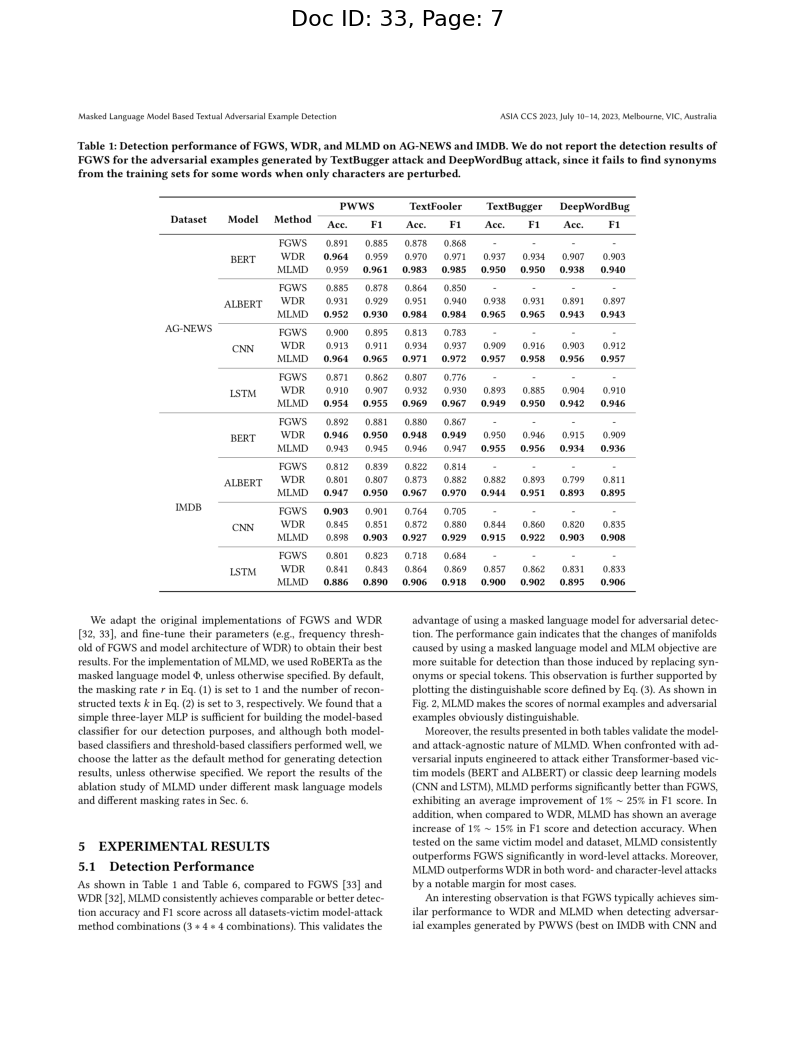

Visualizing: Doc ID: 33, Page: 13, Score: 11.6875, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf


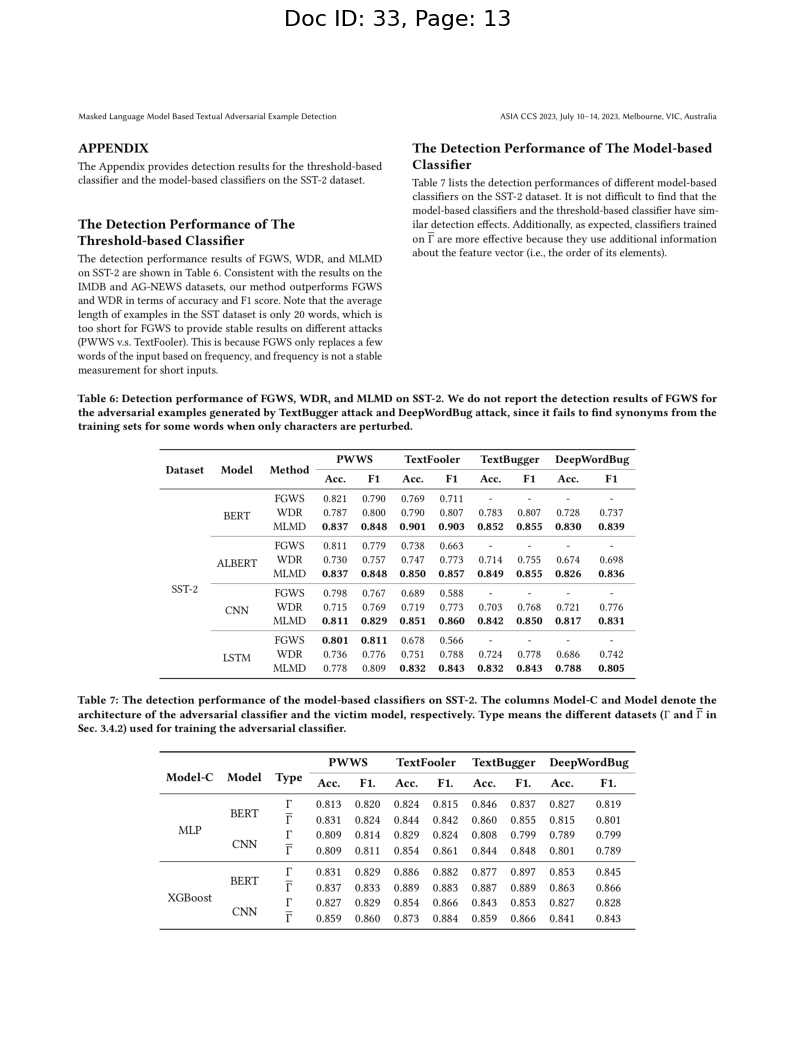

Visualizing: Doc ID: 33, Page: 11, Score: 11.625, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf


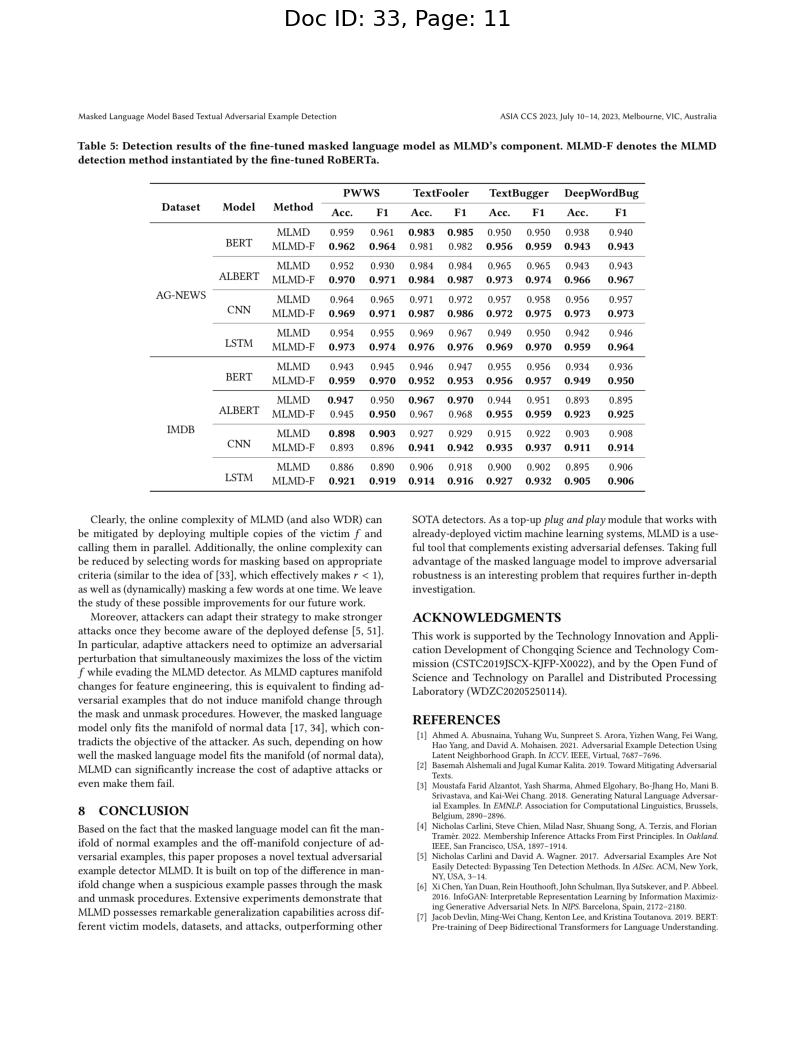

Visualizing: Doc ID: 10, Page: 1, Score: 11.5625, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2012.09852.pdf


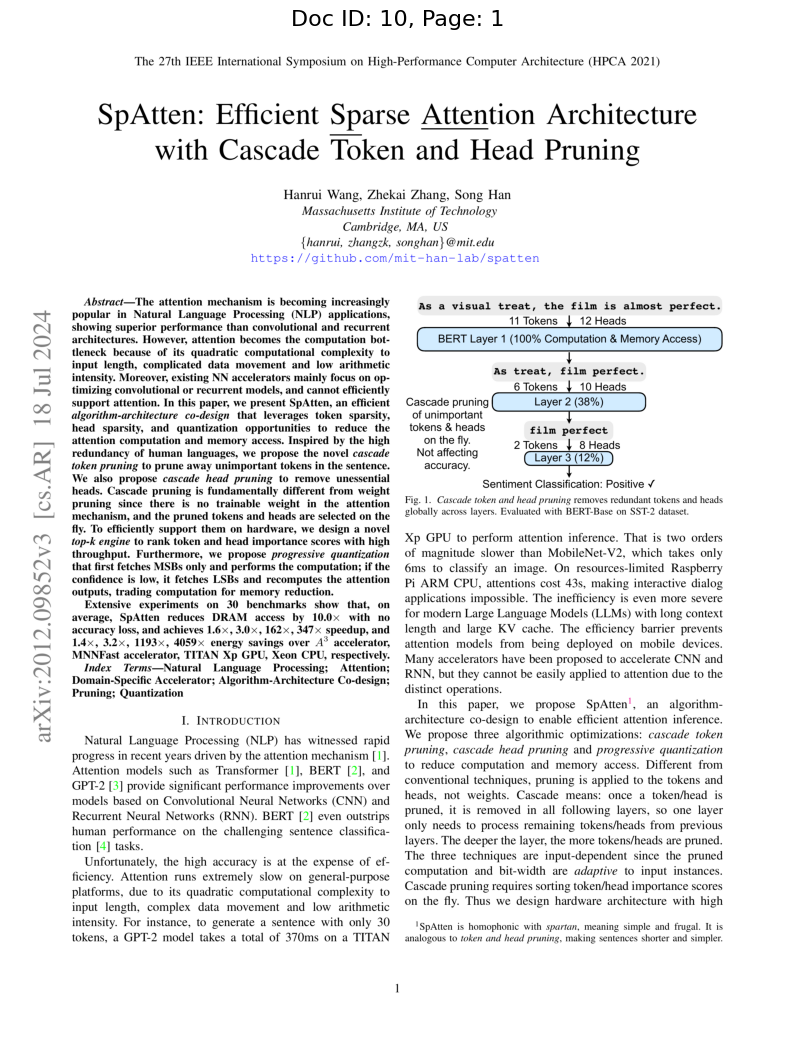

Visualizing: Doc ID: 33, Page: 4, Score: 11.5, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf


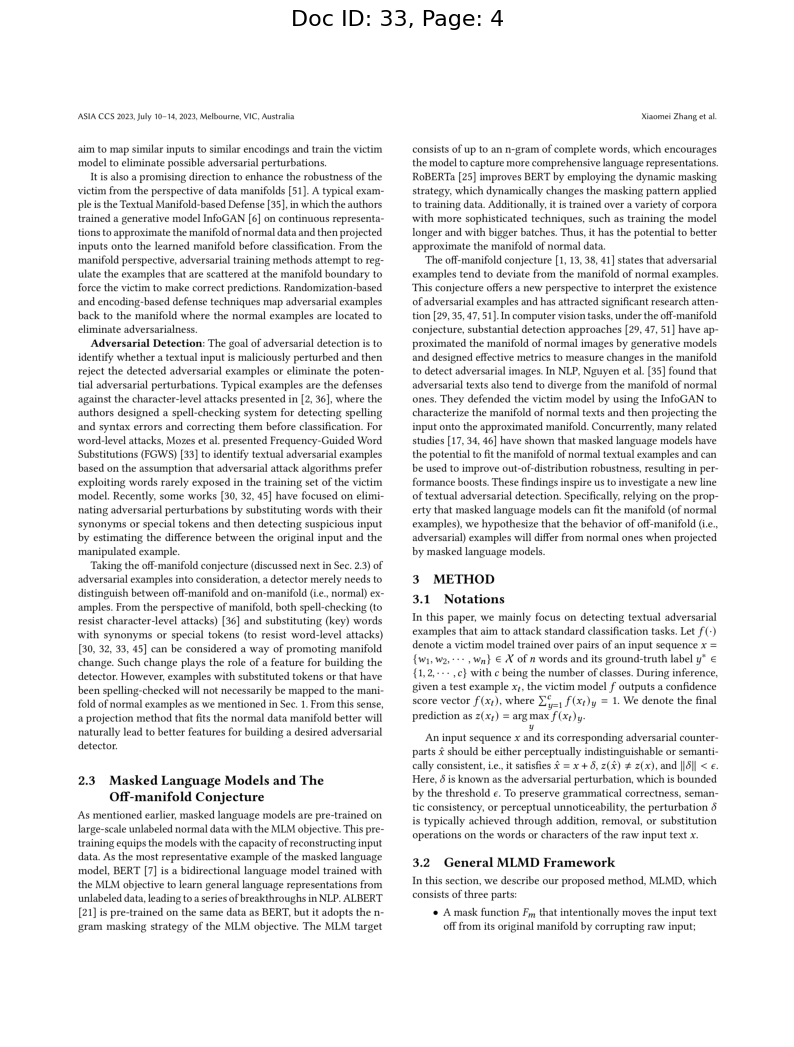

In [2]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# Base path for the PDFs
base_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/"

# Iterate through search results and visualize the pages
for result in results:
    # Construct the full file path
    pdf_path = base_path + result.metadata['filename']  # Combine base path with metadata

    # Get the page number (1-indexed)
    page_number = result.page_num

    try:
        # Convert the specific page to an image with higher DPI
        pages = convert_from_path(pdf_path, dpi=300)  # Increase DPI for better resolution
        
        if page_number > len(pages) or page_number < 1:
            print(f"Page {page_number} does not exist in {result.doc_id}.")
            continue
        
        # Get the specific page image (convert 1-based to 0-based index)
        page_image = pages[page_number - 1]
        
        # Display the page
        print(f"Visualizing: Doc ID: {result.doc_id}, Page: {page_number}, Score: {result.score}, Path: {pdf_path}")
        
        plt.figure(figsize=(10, 14))  # Set a larger figure size (width, height in inches)
        plt.imshow(page_image)
        plt.axis("off")  # Hide axes for better visualization
        plt.title(f"Doc ID: {result.doc_id}, Page: {page_number}", fontsize=16)
        plt.show()

    except Exception as e:
        print(f"Error processing {pdf_path} (Doc ID: {result.doc_id}): {e}")


This works fine, however it retrieves the whole page, lets use docling to extract tables as images and index them

In [9]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.PDFSerlalizer import DocumentHandler

input_dir = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs"
output_dir = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables"
os.makedirs(output_dir, exist_ok=True)

for pdf in os.listdir(input_dir):
    pdf_path = os.path.join(input_dir, pdf)
    doc = DocumentHandler()
    doc.extract_images(pdf_path, output_dir,verbose=True,export_pages=False,export_figures=False,export_tables=True)

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.10446.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 54.93 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.13856.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 8.21 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2302.10639.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 4.79 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2303.10828.pdf...
Images extracted and saved to /home/tolis/Deskto

Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2207.10286.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 4.31 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2012.09852.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 10.25 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2208.10489.pdf...
Images extracted and saved to /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables in 8.48 seconds.
Image extraction started for /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2204.08989.pdf...
Images extracted and saved to /home/tolis/Deskto

Index those images

In [1]:
from byaldi import RAGMultiModalModel
import os
from pathlib import Path

model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", index_root="./index_byaldi")

metadata = [{"filename":file_name} for file_name in os.listdir("/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables")]

index_name = "cs_ai_2024_tables"

model.index(
    input_path=Path("/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables"),
    index_name=index_name,
    store_collection_with_index=False,
    metadata=metadata,
    overwrite=True
)

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2209.14875-table-1.png
Added page 1 of document 0 to index.
Index exported to index_byaldi/cs_ai_2024_tables
Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2204.02283-table-3.png
Added page 1 of document 1 to index.
Index exported to index_byaldi/cs_ai_2024_tables
Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2302.13696-table-4.png
Added page 1 of document 2 to index.
Index exported to index_byaldi/cs_ai_2024_tables
Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2303.10446-table-1.png
Added page 1 of document 3 to index.
Index exported to index_byaldi/cs_ai_2024_tables
Indexing file: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.04067-table-5.png
Added page 1 of 

{0: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2209.14875-table-1.png',
 1: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2204.02283-table-3.png',
 2: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2302.13696-table-4.png',
 3: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2303.10446-table-1.png',
 4: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.04067-table-5.png',
 5: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2106.02926-table-2.png',
 6: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2209.07042-table-2.png',
 7: '/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.05292-table-4.png',
 8: '/home/tolis/Desktop/tolis/DNN/proje

In [2]:
from byaldi import RAGMultiModalModel
from pathlib import Path

index_name = "cs_ai_2024_tables"

model = RAGMultiModalModel.from_index(index_path=index_name, index_root="/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/index_byaldi")

query = "Tables that mention BERT"

results = model.search(query, k=5)

for result in results:
    print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score} metadata {result.metadata}")

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Doc ID: 293, Page: 1, Score: 12.0625 metadata {'filename': '2304.08767-table-8.png'}
Doc ID: 192, Page: 1, Score: 11.875 metadata {'filename': '2304.08767-table-3.png'}
Doc ID: 399, Page: 1, Score: 11.8125 metadata {'filename': '2304.08767-table-1.png'}
Doc ID: 27, Page: 1, Score: 11.625 metadata {'filename': '2304.08767-table-9.png'}
Doc ID: 66, Page: 1, Score: 11.5 metadata {'filename': '2304.08767-table-2.png'}


Visualizing: Doc ID: 293, Page: 1, Score: 12.0625, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-8.png


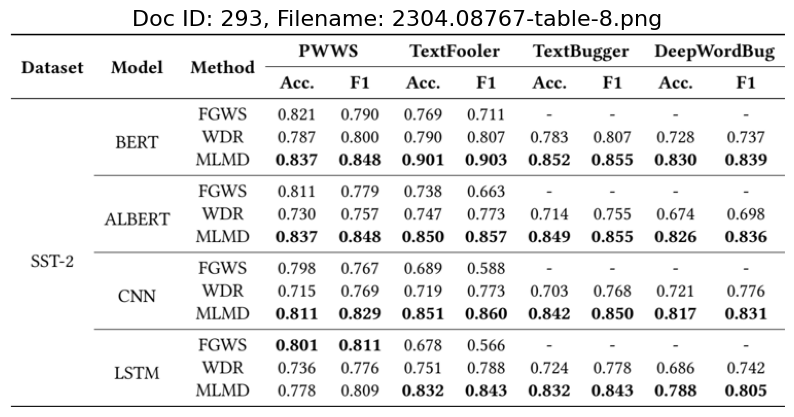

Visualizing: Doc ID: 192, Page: 1, Score: 11.875, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-3.png


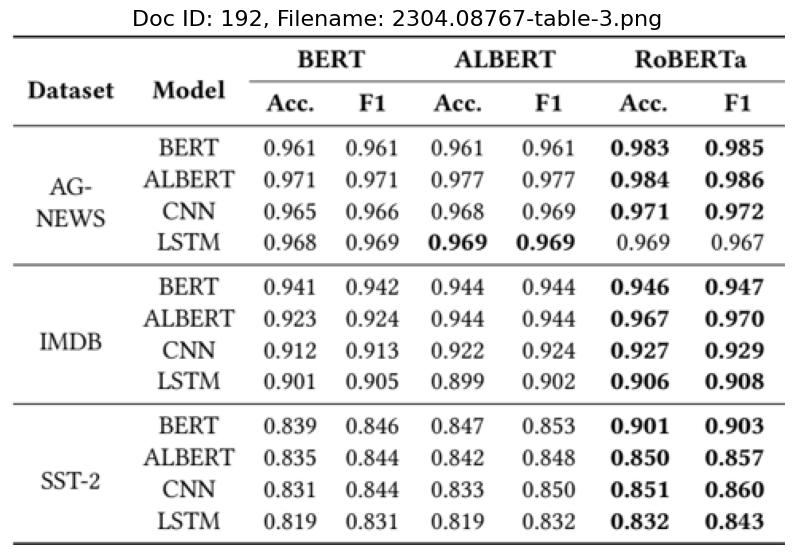

Visualizing: Doc ID: 399, Page: 1, Score: 11.8125, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-1.png


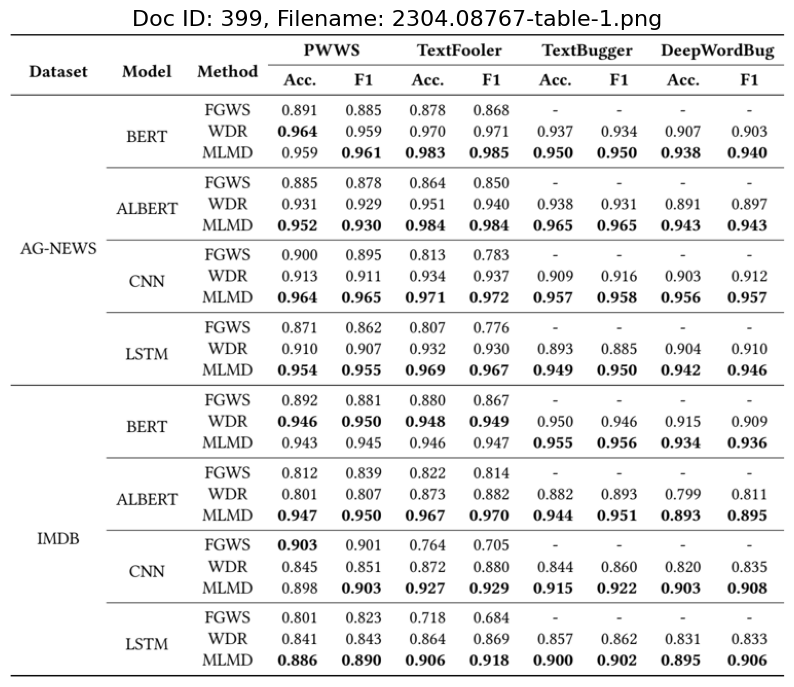

Visualizing: Doc ID: 27, Page: 1, Score: 11.625, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-9.png


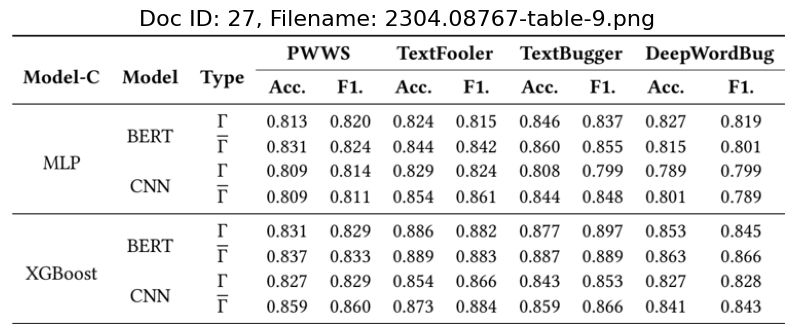

Visualizing: Doc ID: 66, Page: 1, Score: 11.5, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-2.png


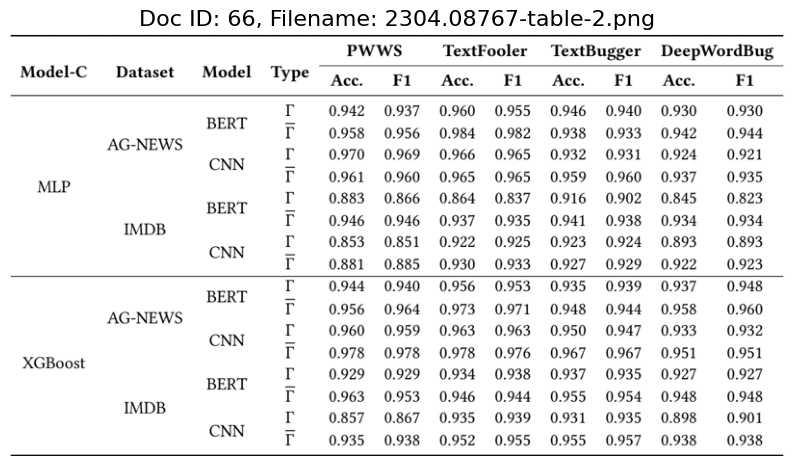

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Base path for the PNG files
base_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables"

# Iterate through the search results and visualize the images
for result in results:
    # Construct the full file path
    image_path = os.path.join(base_path, result.metadata['filename'])
    
    try:
        # Open the image using Pillow
        image = Image.open(image_path)
        
        # Display the image
        print(f"Visualizing: Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}, Path: {image_path}")
        
        # Use matplotlib to display
        plt.figure(figsize=(10, 10))  # Set a larger figure size if needed
        plt.imshow(image)
        plt.axis("off")  # Hide axes for better visualization
        plt.title(f"Doc ID: {result.doc_id}, Filename: {result.metadata['filename']}", fontsize=16)
        plt.show()

    except Exception as e:
        print(f"Error processing {image_path} (Doc ID: {result.doc_id}): {e}")


While this works for text, that is of course usefull, we will need to focus on tables, lets see what we get if we serialize the tables in markdown format, we will use docling to serialize the pdf retrieved above

In [7]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.PDFSerlalizer import DocumentHandler

output_dir = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/tables_2304.08767/"
pdf_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf"
doc = DocumentHandler()
doc.export_tables_from_pdf(pdf_path, output_dir, export_format="markdown", mode=None, verbose=True)


Document converted and tables exported in 6.09 seconds.


In [13]:
import os

# Define the folder path
folder_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/tables_2304.08767"

# Iterate over Markdown files and print their content
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as file:
        content = file.read()
        print(f"### {file_name}\n")
        print(content)
        print("\n" + "#" * 50 + "\n")  # Separator for clarity


### 2304.08767-table-8.markdown

**Caption:** Table 6: Detection performance of FGWS, WDR, and MLMD on SST-2. We do not report the detection results of FGWS for the adversarial examples generated by TextBugger attack and DeepWordBug attack, since it fails to /find synonyms from the training sets for some words when only characters are perturbed.Table 7: The detection performance of the model-based classi/fiers on SST-2. The columns Model-C and Model denote the architecture of the adversarial classi/fier and the victim model, respectively. Type means the di/fferent datasets ( Γ and Γ in Sec. 3.4.2) used for training the adversarial classi/fier.

| Dataset   | Model.Model   | Method.Method   |   PWWS.Acc. |   PWWS.F1 |   TextFooler.Acc. |   TextFooler.F1 | TextBugger.Acc.   | TextBugger.F1   | DeepWordBug.Acc.   | DeepWordBug.F1   |
|:----------|:--------------|:----------------|------------:|----------:|------------------:|----------------:|:------------------|:----------------|:-------

In [14]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.PDFSerlalizer import DocumentHandler

output_dir = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/tables_2304.08767_accurate/"
pdf_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_pdfs/2304.08767.pdf"
doc = DocumentHandler()
doc.export_tables_from_pdf(pdf_path, output_dir, export_format="markdown", mode="accurate", verbose=True)


Document converted and tables exported in 15.19 seconds.


In [15]:
import os

# Define the folder path
folder_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/tables_2304.08767_accurate"

# Iterate over Markdown files and print their content
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as file:
        content = file.read()
        print(f"### {file_name}\n")
        print(content)
        print("\n" + "#" * 50 + "\n")  # Separator for clarity


### 2304.08767-table-8.markdown

**Caption:** Table 6: Detection performance of FGWS, WDR, and MLMD on SST-2. We do not report the detection results of FGWS for the adversarial examples generated by TextBugger attack and DeepWordBug attack, since it fails to /find synonyms from the training sets for some words when only characters are perturbed.Table 7: The detection performance of the model-based classi/fiers on SST-2. The columns Model-C and Model denote the architecture of the adversarial classi/fier and the victim model, respectively. Type means the di/fferent datasets ( Γ and Γ in Sec. 3.4.2) used for training the adversarial classi/fier.

| Dataset.Dataset   | Model.Method   |   PWWS.Acc. |   PWWS.F1 |   TextFooler.Acc. |   TextFooler.F1 | TextBugger.Acc.   | TextBugger.F1   | DeepWordBug.Acc.   | DeepWordBug.F1   |
|:------------------|:---------------|------------:|----------:|------------------:|----------------:|:------------------|:----------------|:-------------------|:----

Both accurate and simple methods generate tables for references as well, we need to tacle this. Anyway, lets just use as query the markdown of one of the tables and see what we get from the RAG.

In [1]:
from byaldi import RAGMultiModalModel
from pathlib import Path

index_name = "cs_ai_2024_tables"

model = RAGMultiModalModel.from_index(index_path=index_name, index_root="/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/index_byaldi")

query = """
| Dataset   | Model   |   BERT.Acc. |   BERT.F1 |   ALBERT.Acc. |   ALBERT.F1 |   RoBERTa.Acc. |   RoBERTa.F1 |
|:----------|:--------|------------:|----------:|--------------:|------------:|---------------:|-------------:|
| AG- NEWS  | BERT    |       0.961 |     0.961 |         0.961 |       0.961 |          0.983 |        0.985 |
| AG- NEWS  | ALBERT  |       0.971 |     0.971 |         0.977 |       0.977 |          0.984 |        0.986 |
| AG- NEWS  | CNN     |       0.965 |     0.966 |         0.968 |       0.969 |          0.971 |        0.972 |
| AG- NEWS  | LSTM    |       0.968 |     0.969 |         0.969 |       0.969 |          0.969 |        0.967 |
| IMDB      | BERT    |       0.941 |     0.942 |         0.944 |       0.944 |          0.946 |        0.947 |
| IMDB      | ALBERT  |       0.923 |     0.924 |         0.944 |       0.944 |          0.967 |        0.97  |
| IMDB      | CNN     |       0.912 |     0.913 |         0.922 |       0.924 |          0.927 |        0.929 |
| IMDB      | LSTM    |       0.901 |     0.905 |         0.899 |       0.902 |          0.906 |        0.908 |
| SST-2     | BERT    |       0.839 |     0.846 |         0.847 |       0.853 |          0.901 |        0.903 |
| SST-2     | ALBERT  |       0.835 |     0.844 |         0.842 |       0.848 |          0.85  |        0.857 |
| SST-2     | CNN     |       0.831 |     0.844 |         0.833 |       0.85  |          0.851 |        0.86  |
| SST-2     | LSTM    |       0.819 |     0.831 |         0.819 |       0.832 |          0.832 |        0.843 |
"""

results = model.search(query, k=15)

for result in results:
    print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score} metadata {result.metadata}")

/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
/home/tolis/Desktop/tolis/DNN/project/img2table/lib/python3.12/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Doc ID: 192, Page: 1, Score: 556.0 metadata {'filename': '2304.08767-table-3.png'}
Doc ID: 399, Page: 1, Score: 520.0 metadata {'filename': '2304.08767-table-1.png'}
Doc ID: 370, Page: 1, Score: 516.0 metadata {'filename': '2304.08767-table-5.png'}
Doc ID: 293, Page: 1, Score: 480.0 metadata {'filename': '2304.08767-table-8.png'}
Doc ID: 66, Page: 1, Score: 474.0 metadata {'filename': '2304.08767-table-2.png'}
Doc ID: 416, Page: 1, Score: 466.0 metadata {'filename': '2304.08767-table-4.png'}
Doc ID: 379, Page: 1, Score: 422.0 metadata {'filename': '2112.02690-table-6.png'}
Doc ID: 27, Page: 1, Score: 414.0 metadata {'filename': '2304.08767-table-9.png'}
Doc ID: 142, Page: 1, Score: 408.0 metadata {'filename': '2207.10286-table-1.png'}
Doc ID: 117, Page: 1, Score: 408.0 metadata {'filename': '2304.03468-table-2.png'}
Doc ID: 143, Page: 1, Score: 404.0 metadata {'filename': '2208.10489-table-5.png'}
Doc ID: 236, Page: 1, Score: 400.0 metadata {'filename': '2207.14000-table-4.png'}
Doc ID

Visualizing: Doc ID: 192, Page: 1, Score: 556.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-3.png


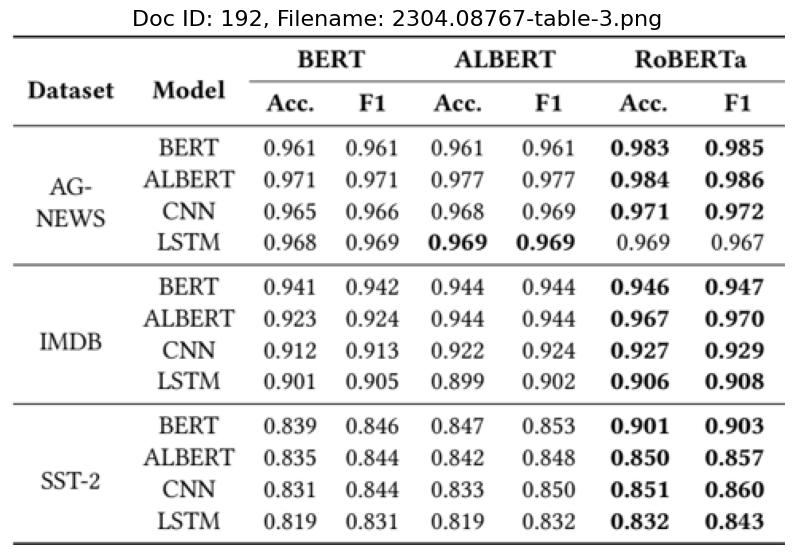

Visualizing: Doc ID: 399, Page: 1, Score: 520.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-1.png


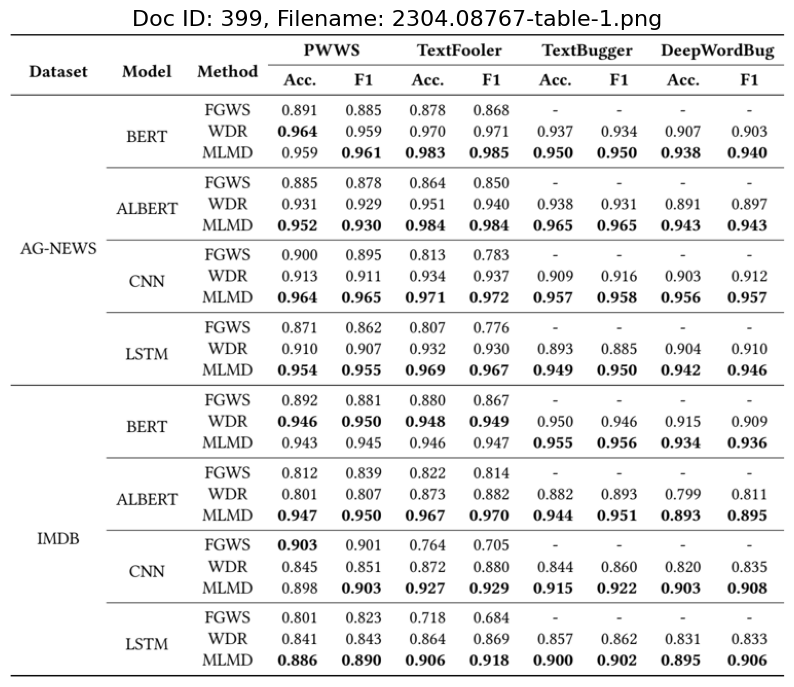

Visualizing: Doc ID: 370, Page: 1, Score: 516.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-5.png


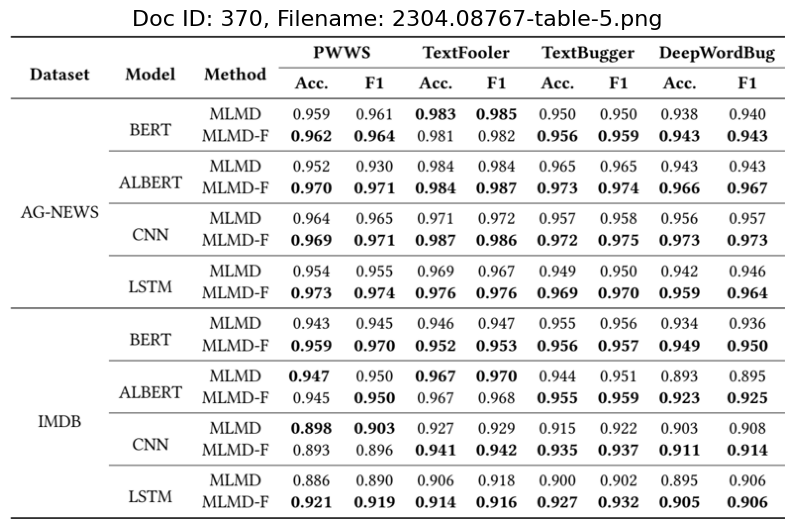

Visualizing: Doc ID: 293, Page: 1, Score: 480.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-8.png


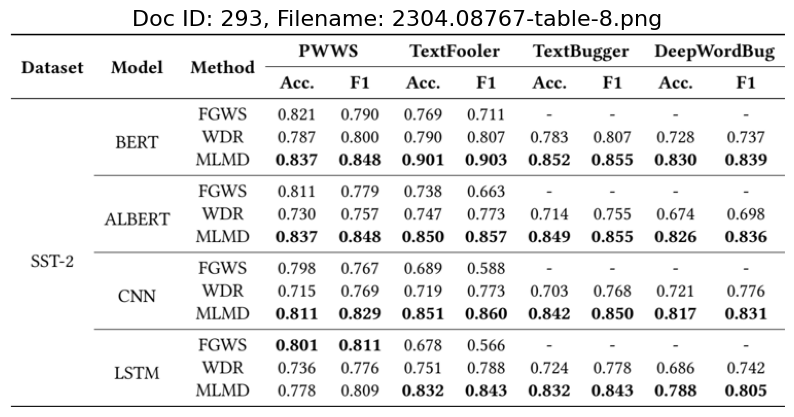

Visualizing: Doc ID: 66, Page: 1, Score: 474.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-2.png


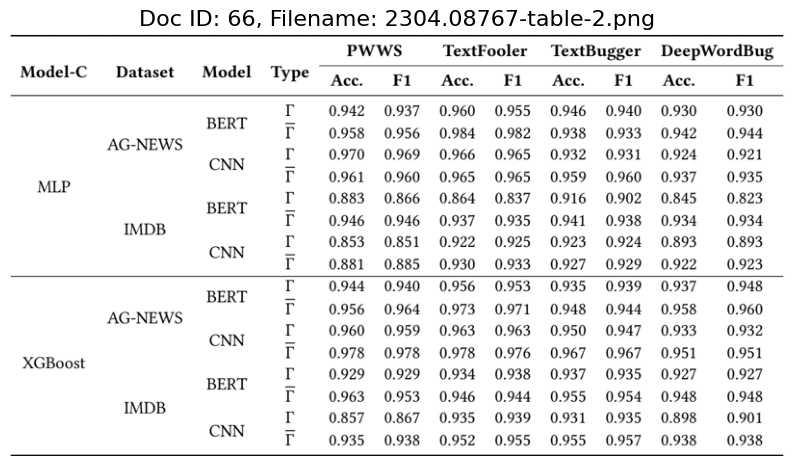

Visualizing: Doc ID: 416, Page: 1, Score: 466.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-4.png


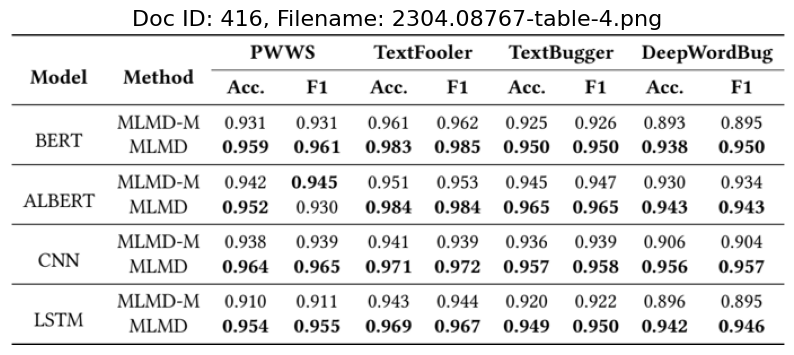

Visualizing: Doc ID: 379, Page: 1, Score: 422.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2112.02690-table-6.png


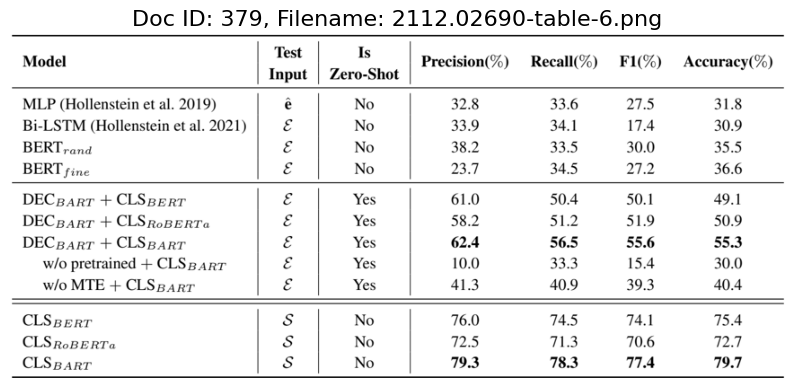

Visualizing: Doc ID: 27, Page: 1, Score: 414.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.08767-table-9.png


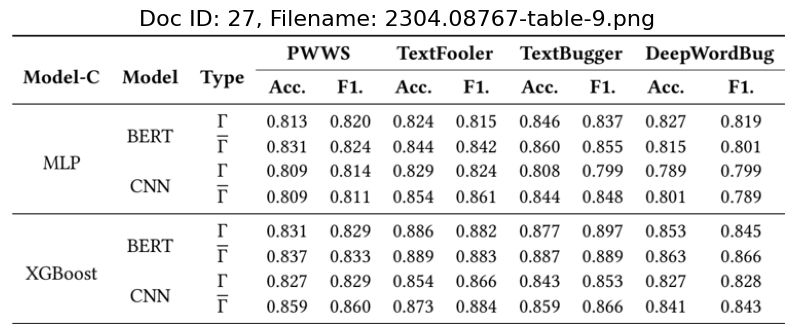

Visualizing: Doc ID: 142, Page: 1, Score: 408.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2207.10286-table-1.png


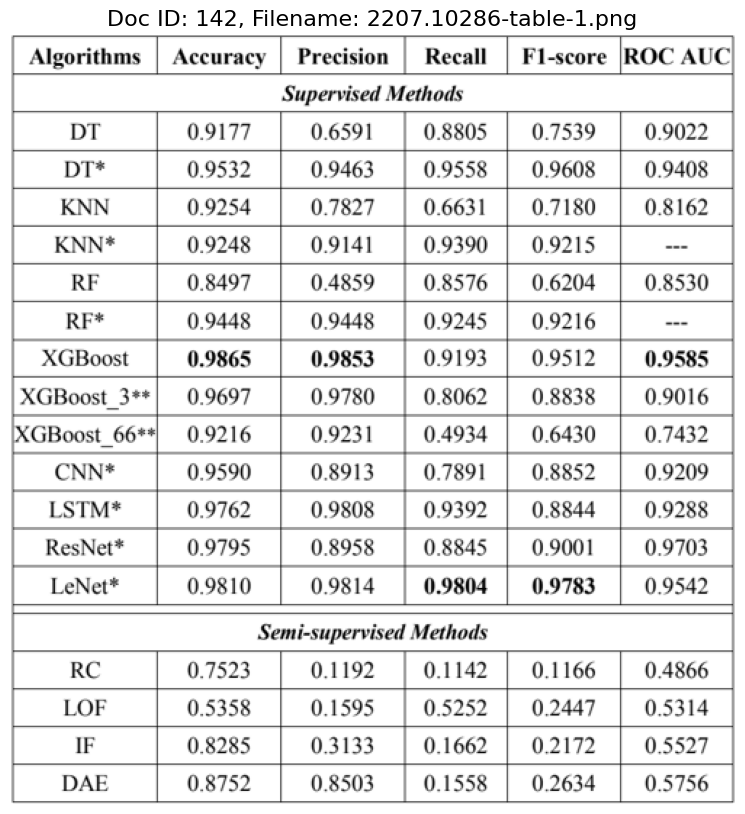

Visualizing: Doc ID: 117, Page: 1, Score: 408.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.03468-table-2.png


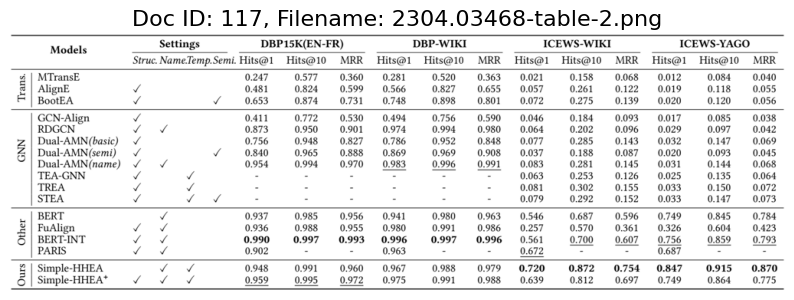

Visualizing: Doc ID: 143, Page: 1, Score: 404.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2208.10489-table-5.png


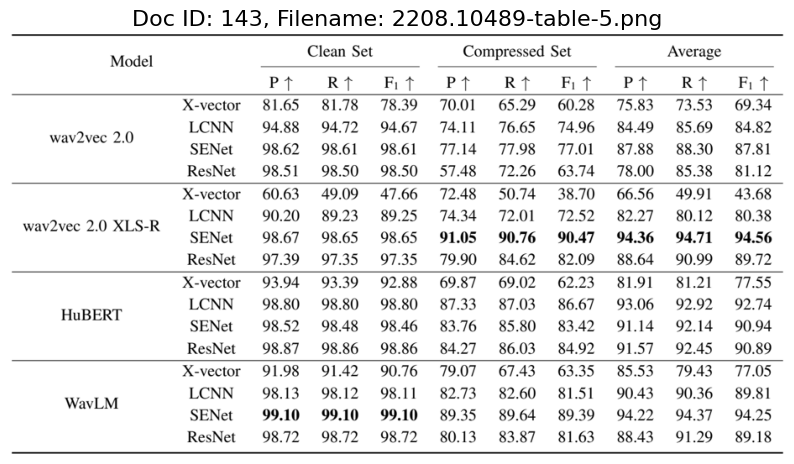

Visualizing: Doc ID: 236, Page: 1, Score: 400.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2207.14000-table-4.png


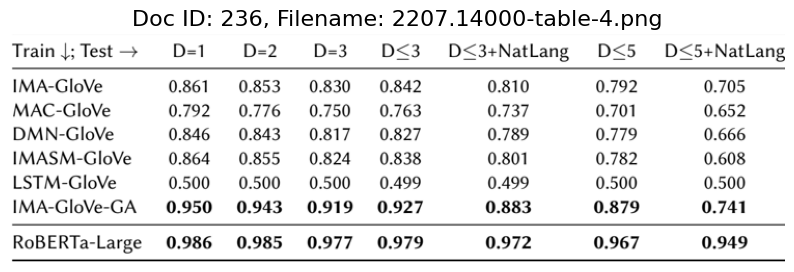

Visualizing: Doc ID: 84, Page: 1, Score: 398.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2208.10489-table-4.png


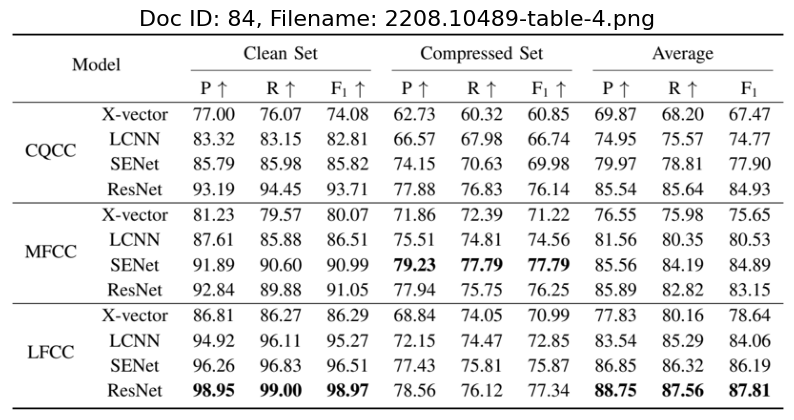

Visualizing: Doc ID: 215, Page: 1, Score: 390.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2304.10045-table-5.png


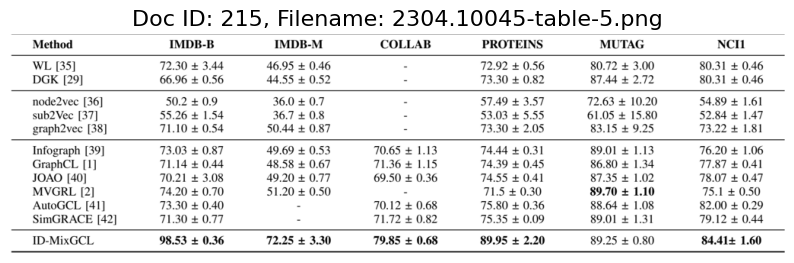

Visualizing: Doc ID: 175, Page: 1, Score: 388.0, Path: /home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables/2210.07113-table-1.png


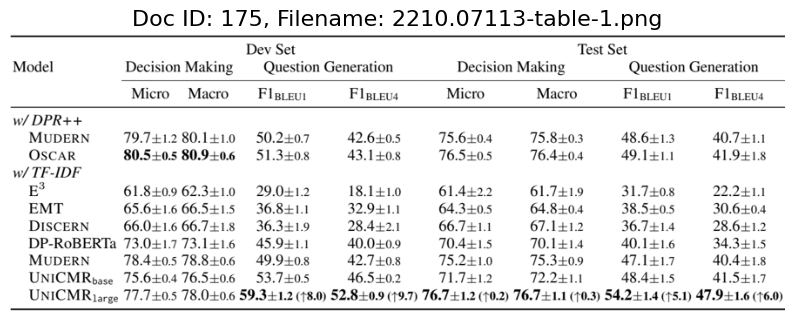

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Base path for the PNG files
base_path = "/home/tolis/Desktop/tolis/DNN/project/DeepLearning_2024_2025_DSIT/demos/cs_ai_2024_tables"

# Iterate through the search results and visualize the images
for result in results:
    # Construct the full file path
    image_path = os.path.join(base_path, result.metadata['filename'])
    
    try:
        # Open the image using Pillow
        image = Image.open(image_path)
        
        # Display the image
        print(f"Visualizing: Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}, Path: {image_path}")
        
        # Use matplotlib to display
        plt.figure(figsize=(10, 10))  # Set a larger figure size if needed
        plt.imshow(image)
        plt.axis("off")  # Hide axes for better visualization
        plt.title(f"Doc ID: {result.doc_id}, Filename: {result.metadata['filename']}", fontsize=16)
        plt.show()

    except Exception as e:
        print(f"Error processing {image_path} (Doc ID: {result.doc_id}): {e}")


What we see is that the first result is the same table as image, as expected, then there are tables from the same pdf that are relevant and finally some talbes from other pdfs that are relevant as well (we can observe that all mention bert)

Of course eveything works for regular images of scientific papers as well. While ColPali's input for RAG is text, which is really useful in cases we have converted the table into markdown, since we can also pass the caption, we might consider converting it to get as input images, this is definetely doable.